In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os, sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from pandas import DataFrame
import torch, torch.nn as nn
import numpy as np
import random
import networkx as nx
from utils_ac import random_walk, ReplayBuffer, PathsBuffer, get_states_emb, convert_to_walk, \
    is_valid_path, covering_walk, is_valid_path_new
from problem_ac import GraphProblem, generate_erdos_renyi_problems, generate_regular_problems
from network_ac import ActorCriticActLSTM, ActorCriticAct
import time

In [3]:
sys.path.insert(0, '..')
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [4]:
#params
NUM_PROBLEMS = 15
NUM_EPISODES = 10
NUM_VERTICES = 15
DEGREE = 6
THRESHOLD = 0.75
PATHS_BUFFER_CAPACITY = 100
REPLAY_BUFFER_CAPACITY = 100

In [5]:
problem_maker = generate_regular_problems(num_vertices=NUM_VERTICES, degree=DEGREE)

In [6]:
agent = ActorCriticAct(hid_size=256, gcn_size=256, vertex_emb_size=64)

In [7]:
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

In [8]:
#initialize buffers
path_buffer = PathsBuffer(capacity=PATHS_BUFFER_CAPACITY, threshold=THRESHOLD)
train_buffer = ReplayBuffer(capacity=REPLAY_BUFFER_CAPACITY)

In [9]:
actor_losses = []
critic_losses = []

In [10]:
problems = [next(problem_maker) for i in range(NUM_PROBLEMS)]

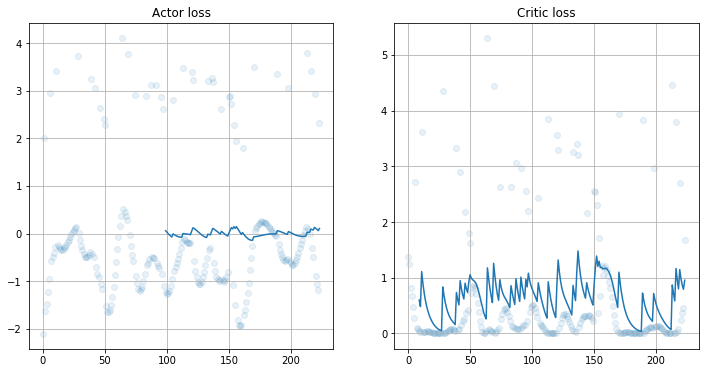

100%|██████████| 15/15 [1:56:19<00:00, 627.38s/it]


In [11]:
i = 0

for k in trange(len(problems)):
    
    problem = problems[k]
    
    edges = problem.get_edges()

    for vertex in problem.get_actions():

        path_buffer.flush()
        
        PATH_LENGTH = 2*problem.num_edges + 1        
        i += 1 
        
        for episode in range(NUM_EPISODES):
            
            problem.path = [vertex]

            path = problem.get_state()
            
            states = []
            actions = []
            
            with torch.no_grad():
                graph_emb = agent.embed_graph(problem.edges)

            for _ in range(PATH_LENGTH-1):
                with torch.no_grad():
                    probs, v = agent.get_dist([path], graph_emb, edges)
                
                valids = edges[path[-1]]
                    
                dist = torch.distributions.Categorical(probs[0])

                next_vertex = dist.sample().item()
                
                next_vertex = valids[next_vertex]

                actions.append(next_vertex)
                
                states.append(path)

                path = problem.get_next_state(path, next_vertex)
            
            path_buffer.push(path)
                
            if len(path_buffer) >= 10: 
                reward = path_buffer.rank_path(path)
                rewards = torch.FloatTensor([reward]*(PATH_LENGTH-1))
                
                graph_emb = agent.embed_graph(problem.edges)
                
                probs, values = agent.get_dist(states, graph_emb, edges)
                
                log_probs = []
                for i, dist in enumerate(probs):
                    valids = edges[states[i][-1]]
                    a = valids.index(actions[i])
                    m = torch.distributions.Categorical(dist)
                    log_prob = m.log_prob(torch.tensor(a))
                    log_probs.append(log_prob)

                advantage = rewards - values

                actor_loss  = -(torch.stack(log_probs) * advantage.detach()).mean()
                critic_loss = advantage.pow(2).mean()
                                                          
                actor_losses.append(actor_loss.item())
                critic_losses.append(critic_loss.item())

                loss = actor_loss + critic_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if i % 2 == 0:
                clear_output(True)
                plt.figure(figsize=[12, 6])
                plt.subplot(1,2,1)
                plt.title('Actor loss'); plt.grid()
                plt.scatter(np.arange(len(actor_losses)), actor_losses, alpha=0.1)
                plt.plot(moving_average(actor_losses, span=100, min_periods=100))

                plt.subplot(1,2,2)
                plt.title('Critic loss'); plt.grid()
                plt.scatter(np.arange(len(critic_losses)), critic_losses, alpha=0.1)
                plt.plot(moving_average(critic_losses, span=10, min_periods=10))
                plt.show()

In [1]:
probs

NameError: name 'probs' is not defined

In [64]:
print(path_buffer.buffer[-1])

[14, 2, 7, 9, 11, 5, 11, 13, 2, 6, 2, 7, 11, 13, 14, 0, 2, 14, 4, 13, 14, 4, 11, 14, 11, 4, 14, 2, 4, 11, 14, 0, 1, 7, 3, 7, 3, 7, 11, 9, 3, 13, 3, 7, 3, 6, 3, 10, 1, 5, 12, 8, 14, 11, 4, 11, 9, 3, 13, 12, 13, 12, 8, 1, 5, 10, 12, 5, 10, 1, 8, 1, 0, 2, 7, 0, 7, 11, 4, 14, 4, 11, 4, 11, 13, 2, 4, 13, 4, 13, 14]


In [56]:
print(agent)

ActorCriticAct(
  (gcn): GraphConvolutionBlock(
    (convs): ModuleList(
      (0): GraphConvolution (64 -> 256)
      (1): GraphConvolution (256 -> 256)
    )
    (activation): ELU(alpha=1.0)
    (dense): Linear(in_features=256, out_features=256, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Softmax()
  )
)


In [68]:
def test_agent(agent, problem, vertex):
    problem.path = [vertex]
    edges = problem.get_edges()
    with torch.no_grad():
        graph_emb = agent.embed_graph(problem.edges)
        path = problem.get_state()
        for _ in range(PATH_LENGTH-1):
            probs, v = agent.get_dist([path], graph_emb, edges)
            valids = edges[path[-1]]  
            dist = torch.distributions.Categorical(probs[0])
            next_vertex = dist.sample().item()
            next_vertex = valids[next_vertex]
            path = problem.get_next_state(path, next_vertex)
    return path

In [69]:
p = next(problem_maker)

In [75]:
test_agent(agent, p, 1)

AttributeError: 'ActorCriticAct' object has no attribute 'lstm'

In [74]:
torch.save(agent, "./net/ActorCriticActv1.pth")

PicklingError: Can't pickle <class 'network_ac.ActorCriticAct'>: it's not the same object as network_ac.ActorCriticAct